In [1]:
words=open('names.txt', 'r').read().splitlines()

In [2]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
min(len(w) for w in words)

2

In [5]:
max(len(w) for w in words)

15

In [6]:
b={}
for w in words[:1]:
    chs=['<S>']+list(w)+['<E>']
    for ch1,ch2 in zip(chs,chs[1:]):
        bigram=(ch1,ch2)
        b[bigram]=b.get(bigram,0)+1

In [7]:
sorted(b.items(),key=lambda kv: -kv[1])

[(('<S>', 'e'), 1),
 (('e', 'm'), 1),
 (('m', 'm'), 1),
 (('m', 'a'), 1),
 (('a', '<E>'), 1)]

In [8]:
import torch

In [9]:
N = torch.zeros((28,28),dtype=torch.int32)

In [10]:
chars=sorted(list(set(''.join(words))))
stoi={s:i for i,s in enumerate(chars)}
stoi['<S>']=26
stoi['<E>']=27

In [ ]:
for w in words:
    chs=['<S>']+list(w)+['<E>']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        N[ix1,ix2]+=1

In [12]:
itos={i:s for s,i in stoi.items()}

(-0.5, 27.5, 27.5, -0.5)

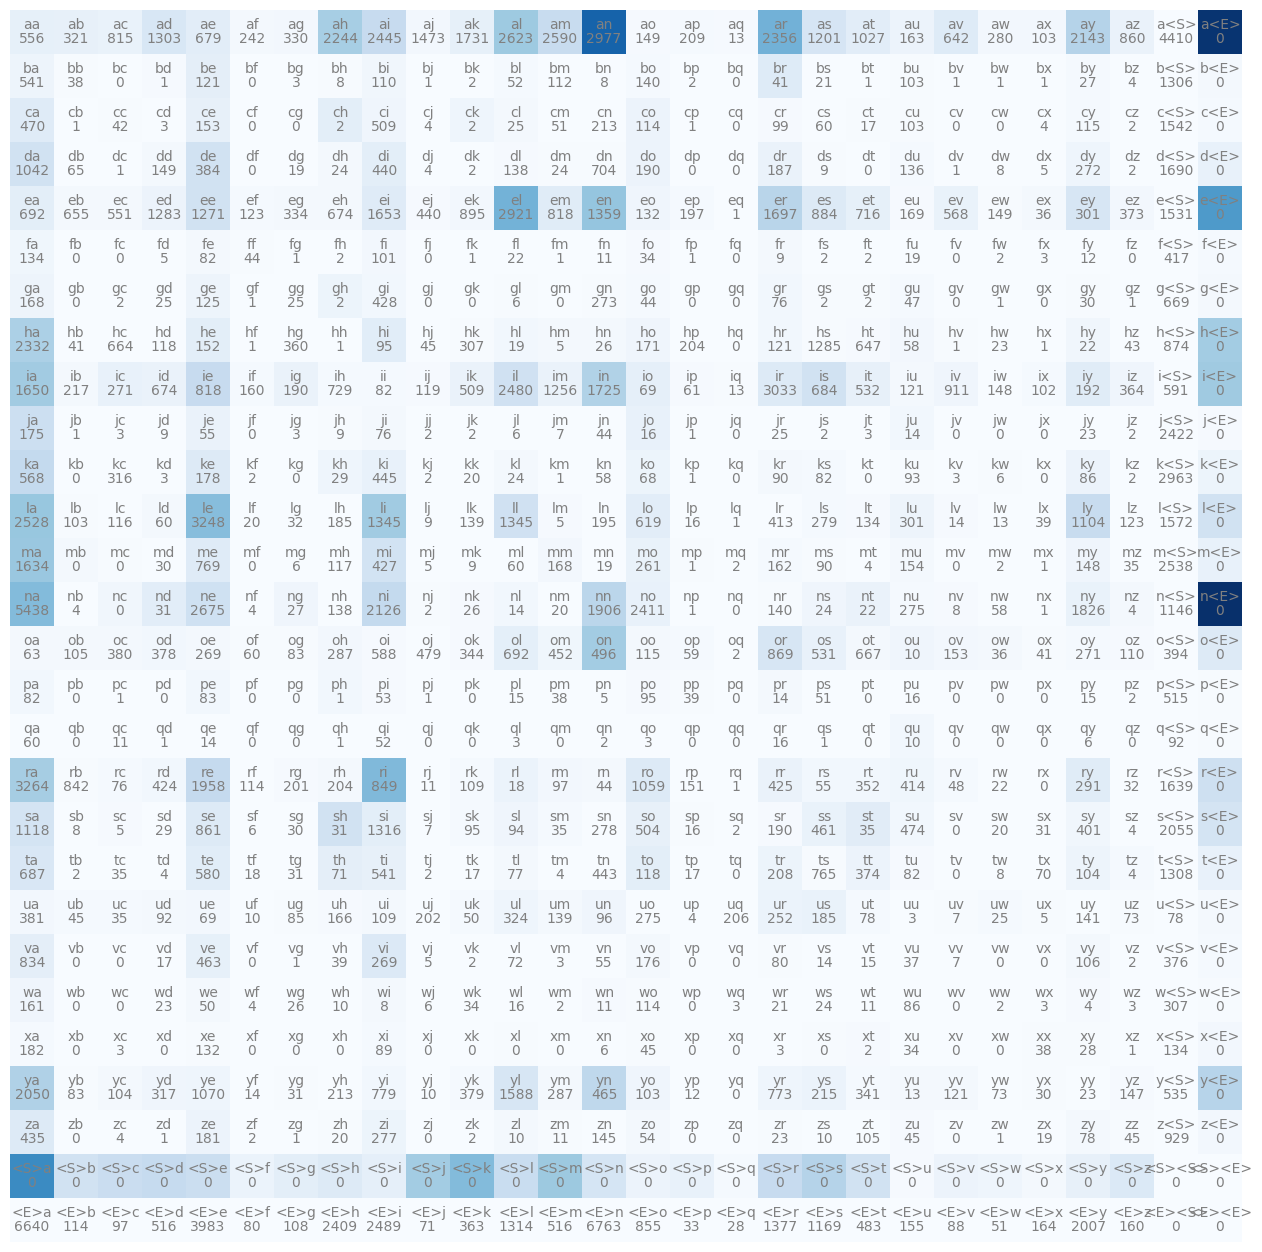

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(28):
    for j in range(28):
        chstr=itos[i]+itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color='gray')
        plt.text(j,i,N[j,i].item(),ha="center",va="top",color='gray')
plt.axis('off')

(-0.5, 26.5, 26.5, -0.5)

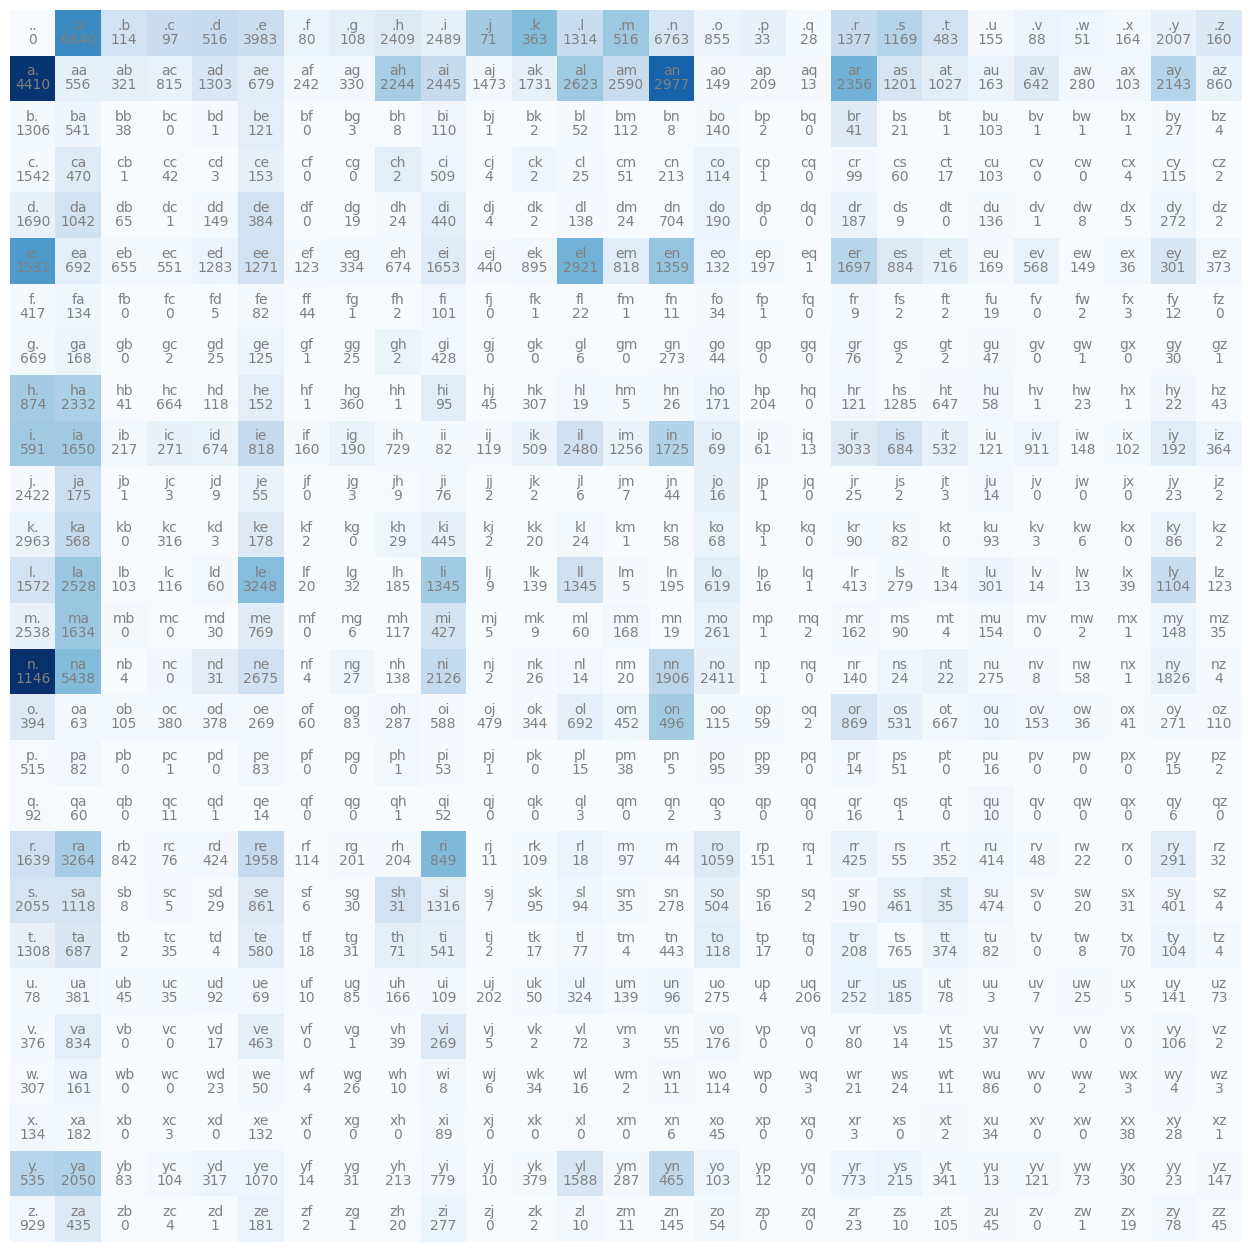

In [17]:
N = torch.zeros((27,27),dtype=torch.int32)
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
for w in words:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        N[ix1,ix2]+=1

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr=itos[i]+itos[j]
        plt.text(j,i,chstr,ha="center",va="bottom",color='gray')
        plt.text(j,i,N[j,i].item(),ha="center",va="top",color='gray')
plt.axis('off')


In [19]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [26]:
p = N[0].float()
p=p/p.sum()

In [28]:
g=torch.Generator().manual_seed(2147483647)
ix=torch.multinomial(p,num_samples=1,replacement=True, generator=g).item()
itos[ix]

'j'

In [ ]:
P=N.float()
P/=P.sum(1,keepdim=True)

Need keepdim=True to make broadcasting work, without it we would have:
27, 27
 1, 27
normalizing the columns instead of the rows

Also use in place operations if possible "/=" since it has the potential to be faster (not creating a new tensor)

In [42]:
g=torch.Generator().manual_seed(2147483647)

for i in range(10):
    out=[]
    ix=0
    while True:
        p=P[ix]
        #p=N[ix].float()
        #p=p/p.sum()
        #p=torch.ones(27)/27.0
        ix=torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix==0:
            break
    print(''.join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.


In [51]:
log_likelihood=0.0
n=0

for w in words:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        prob=P[ix1,ix2]
        logprob=torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f}, {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-559891.7500)
nll=tensor(559891.7500)
nll/n=tensor(2.4541)


In [54]:
log_likelihood=0.0
n=0

for w in ["andrejq"]:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        prob=P[ix1,ix2]
        logprob=torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f}, {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-inf)
nll=tensor(inf)
nll/n=tensor(inf)


shows inf since P(jq)=0 in our model
Add model smoothing for fake counts

In [55]:
P=(N+1).float()
P/=P.sum(1,keepdim=True)

log_likelihood=0.0
n=0

for w in ["andrejq"]:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        prob=P[ix1,ix2]
        logprob=torch.log(prob)
        log_likelihood+=logprob
        n+=1
        #print(f'{ch1}{ch2}: {prob:.4f}, {logprob:.4f}')

print(f'{log_likelihood=}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

log_likelihood=tensor(-27.8672)
nll=tensor(27.8672)
nll/n=tensor(3.4834)


Create training set of bigrams (x,y)
xs - guesses
ys - correct answer

In [64]:
xs, ys=[],[]

for w in words[:1]:
    chs=['.']+list(w)+['.']
    for ch1,ch2 in zip(chs,chs[1:]):
        ix1=stoi[ch1]
        ix2=stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

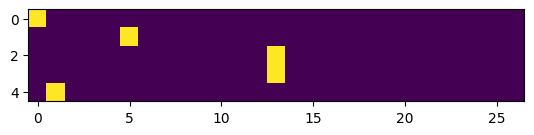

In [ ]:
#one-hot encoding - y axis is position in array, ax axis is number
import torch.nn.functional as F
xenc=F.one_hot(xs,num_classes=27).float()
xenc.shape
plt.imshow(xenc)

In [73]:
W=torch.randn((27,27))
xenc@W

tensor([[ 1.2425, -0.1799, -0.5768, -2.1101,  0.2583, -1.4200, -0.9100,  2.6371,
         -1.2913,  0.4591, -2.4694, -0.0977, -1.7559, -1.5324, -0.4168, -0.2655,
          0.5549, -0.7314,  1.1096, -1.7372, -2.2393, -0.7477,  1.6540,  0.9280,
         -0.8865, -2.6464,  0.2620],
        [-0.1521, -1.4470,  0.9800, -0.8576, -1.4914,  0.7260, -0.7784,  0.3928,
         -1.6764,  0.6481,  0.7934,  1.2167,  1.3629,  1.8238, -0.1069, -1.0590,
         -1.0084,  1.8754, -2.0496, -0.2706,  1.0359, -0.4525, -0.3583, -0.6611,
         -1.1605,  0.2834, -0.7144],
        [-0.2490, -1.1313,  0.7086,  0.1770, -1.0176, -0.7399, -0.7657, -1.2378,
         -2.3772,  0.1667, -0.7535, -1.5153,  1.3027, -1.5944, -2.2256, -0.2230,
         -1.4522, -0.5270, -0.5163, -1.7356,  0.2737,  1.0042,  0.4292,  0.8693,
         -1.1976, -0.8819,  0.5764],
        [-0.2490, -1.1313,  0.7086,  0.1770, -1.0176, -0.7399, -0.7657, -1.2378,
         -2.3772,  0.1667, -0.7535, -1.5153,  1.3027, -1.5944, -2.2256, -0.2230

Interperet xenc@W as log counts

In [ ]:
logits=xenc@W
counts=logits.exp()
probs=counts/counts.sum(1, keepdim=True)
#These last two lies are called soft max
probs

tensor([[0.0843, 0.0203, 0.0137, 0.0029, 0.0315, 0.0059, 0.0098, 0.3399, 0.0067,
         0.0385, 0.0021, 0.0221, 0.0042, 0.0053, 0.0160, 0.0187, 0.0424, 0.0117,
         0.0738, 0.0043, 0.0026, 0.0115, 0.1272, 0.0615, 0.0100, 0.0017, 0.0316],
        [0.0204, 0.0056, 0.0634, 0.0101, 0.0054, 0.0492, 0.0109, 0.0352, 0.0045,
         0.0455, 0.0526, 0.0803, 0.0930, 0.1474, 0.0214, 0.0083, 0.0087, 0.1552,
         0.0031, 0.0182, 0.0670, 0.0151, 0.0166, 0.0123, 0.0075, 0.0316, 0.0116],
        [0.0315, 0.0130, 0.0821, 0.0483, 0.0146, 0.0193, 0.0188, 0.0117, 0.0038,
         0.0478, 0.0190, 0.0089, 0.1488, 0.0082, 0.0044, 0.0323, 0.0095, 0.0239,
         0.0241, 0.0071, 0.0532, 0.1104, 0.0621, 0.0964, 0.0122, 0.0167, 0.0719],
        [0.0315, 0.0130, 0.0821, 0.0483, 0.0146, 0.0193, 0.0188, 0.0117, 0.0038,
         0.0478, 0.0190, 0.0089, 0.1488, 0.0082, 0.0044, 0.0323, 0.0095, 0.0239,
         0.0241, 0.0071, 0.0532, 0.1104, 0.0621, 0.0964, 0.0122, 0.0167, 0.0719],
        [0.0305, 0.0201,

In [ ]:
probs.shape

torch.Size([5, 27])

In [82]:
loss= -probs[torch.arange(5),ys].log().mean()

FORWARD PASS FINISHED

In [78]:
#summary
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
  print('input to the neural net:', x)
  print('output probabilities from the neural net:', probs[i])
  print('label (actual next character):', y)
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  print('log likelihood:', logp.item())
  nll = -logp
  print('negative log likelihood:', nll.item())
  nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0843, 0.0203, 0.0137, 0.0029, 0.0315, 0.0059, 0.0098, 0.3399, 0.0067,
        0.0385, 0.0021, 0.0221, 0.0042, 0.0053, 0.0160, 0.0187, 0.0424, 0.0117,
        0.0738, 0.0043, 0.0026, 0.0115, 0.1272, 0.0615, 0.0100, 0.0017, 0.0316])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.005879917647689581
log likelihood: -5.136212348937988
negative log likelihood: 5.136212348937988
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0204, 0.0056, 0.0634, 0.0101, 0.0054, 0.0492, 0.0109, 0.0352, 0.0045,
        0.0455, 0.0526, 0.0803, 0.0930, 0.1474, 0.0214, 0.0083, 0.0087, 0.1552,
        0.0031, 0.0182, 0.0670, 0.0151, 0.0166, 0.0123, 0.0075, 0.0316, 0.0116])
label (actual next character): 13
probability assigned by the net to the the correct character: 0

--OPTIMIZATION/CLEANUP--

In [83]:
xs

tensor([ 0,  5, 13, 13,  1])

In [84]:
ys

tensor([ 5, 13, 13,  1,  0])

In [85]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [92]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
loss = -probs[torch.arange(5), ys].log().mean()

In [93]:
print(loss.item())

3.7492127418518066


BACKWARD PASS

In [88]:
W.grad=None #set to zero the gradient
loss.backward()

In [89]:
W.shape

torch.Size([27, 27])

In [ ]:
W.grad #positive in here means that it has a positive influence on loss W[x]+h increases loss

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

In [ ]:
#Update weights
W.data+=-0.1*W.grad

Put it all together

In [100]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
# gradient descent
for k in range(100):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() #second term tries to make Ws zero, adds a bias to the loss and tries to "uniformize" the predictions
  #print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad
print(loss.item())

2.4827513694763184


In [106]:

# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
prelay.
a.
nn.


stil not great...

Summary:
1. Introduced bigram character level language model
2. Trained, sampled from, and evaluated model using negative log likelihood loss
3. Trained the model in two seperate ways:
    1. We counted up the frequency of the bigrams and normalized
    2. We used the negative log likelihood loss as a guide to optimize the counts array so the loss is minimized (in a gradient based framework)
    - Both of these gave the same result
Next we will be feeding more characters into the neural net and we will complexify to transformers.